<h1><center><font size="25">Skforecast: forecasting series temporales con Python y Scikit-learn</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>Febrero, 2021 (última actualización Septiembre 2022)</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [Predicción (forecasting) de visitas a página web con machine learning](https://www.cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learning.html)
+ [Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html)
+ [Predicción del precio de Bitcoin con Python](https://www.cienciadedatos.net/documentos/py41-forecasting-criptomoneda-bitcoin-machine-learning-python.html)
+[Intervalos de predicción en modelos de forecasting](https://www.cienciadedatos.net/documentos/py42-intervalos-prediccion-modelos-forecasting-machine-learning.html)

## Introducción
<br>

Una serie temporal (*time series*) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de *forecasting* consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

<div>
<img src='./images/forecasting_multi-step.gif' width="600"/>
</div>

A lo largo de este documento, se describe cómo utilizar modelos de regresión de [**Scikit-learn**](https://scikit-learn.org/stable/) para realizar *forecasting* sobre series temporales. En concreto, se hace uso de [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html), una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de **Scikit-learn** a problemas de *forecasting*.

Para casos de uso más detallados visitar [skforecast-examples](https://joaquinamatrodrigo.github.io/skforecast/latest/examples/examples.html).
<br><br>

## Entrenamiento de un modelo de forecasting
<br>

La principal adaptación que se necesita hacer para aplicar modelos de machine learning  a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.

<img src="./images/transform_timeseries.gif" style="width: 550px;">
<br>

<center><font size='2.5'> <i>Transformación de una serie temporal en una matriz de 5 lags y un vector con el valor de la serie que sigue a cada fila de la matriz.</i></font></center>

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.

<img src="./images/matrix_transformation_with_exog_variable.png" style="width: 550px;">

<center><font size='2.5'> <i>Transformación de una serie temporal junto con una variable exógena.</i></font></center>

Una vez que los datos se encuentran reordenados de esta forma, se puede entrenar cualquier modelo de regresión para que aprenda a predecir el siguiente valor de la serie.



## Predicciones *multi-step*
<br>

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ($t_{+1}$), sino todo un intervalo futuro o un punto alejado en el tiempo ($t_{+n}$). A cada paso de predicción se le conoce como *step*. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.
<br><br>

### Recursive multi-step forecasting
<br>

Dado que, para predecir el momento $t_{n}$ se necesita el valor de $t_{n-1}$, y $t_{n-1}$ se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como *recursive forecasting* o *recursive multi-step forecasting* y pueden generarse fácilmente con las clases `ForecasterAutoreg` y `ForecasterAutoregCustom` de la librería **skforecast**.

<div>
<img src='./images/diagrama-multistep-recursiva.png' width="650"/>
</div>

<center><font size='2.5'> <i>Diagrama del proceso de predicción multi-step recursivo para predecir 3 steps a futuro utilizando los últimos 4 lags de la serie como predictores.</i></font></center>

### Direct multi-step forecasting
<br>

El método *direct multi-step forecasting* consiste en entrenar un modelo distinto para cada *step*. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada *step*. Como resultado, las predicciones son independientes unas de otras. 

<img src="./images/diagrama-prediccion-multistep-directa.png" width="700">

<center><font size='2.5'> <i>Diagrama del proceso de predicción multi-step directo, para predecir 3 steps a futuro utilizando los últimos 4 lags de la serie como predictores.</i></font></center>

<br><br>

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase `ForecasterAutoregDirect` de la librería **skforecast**. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas. 

<img src="./images/diagram_skforecast_multioutput.png" style="width: 900px;">

<center><font size='2.5'> <i>Transformación de una serie temporal en en las matrices necesarias para entrenar un modelo direct multi-step forecasting.</i></font></center>
    
<br><br>

### Multiple output forecasting
<br>

Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (*one-shot*). Esta estrategia no está disponible en **skforecast**.
<br><br>

## Forecasting autorregresivo recursivo
<br>

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.
<br>

### Librerías
<br>

Las librerías utilizadas en este documento son:

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

### Datos
<br>

Los datos empleados en los ejemplos de este documento se han obtenido del magnífico libro [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [3]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

La columna `fecha` se ha almacenado como `string`. Para convertirla en `datetime`, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de **Pandas**, se establece como índice. Además, dado que los datos son mensuales, se indica la frecuencia (*Monthly Started 'MS'*).

In [4]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Al establecer una frecuencia con el método `asfreq()`, **Pandas** completa los huecos que puedan existir en la serie temporal con el valor de `Null` con el fin de asegurar la frecuencia indicada. Por ello, se debe comprobar si han aparecido missing values tras esta transformación.

In [5]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


Aunque no es necesario al haber establecido un frecuencia, se puede verificar que la serie temporal esté completa.

In [6]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [7]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


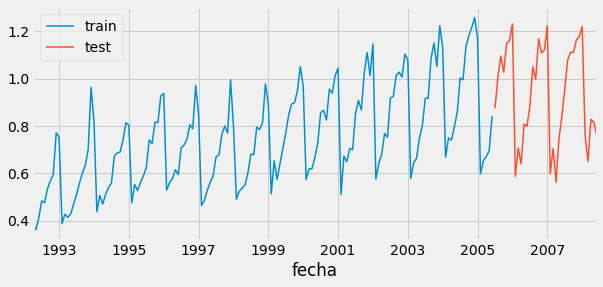

In [8]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg
<br>

Se crea y entrena un modelo `ForecasterAutoreg` a partir de un regresor `RandomForestRegressor` y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [9]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-30 19:41:04 
Last fit date: 2022-09-30 19:41:04 
Skforecast version: 0.5.0 
Python version: 3.9.13 

### Predicciones
<br>

Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).

In [10]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

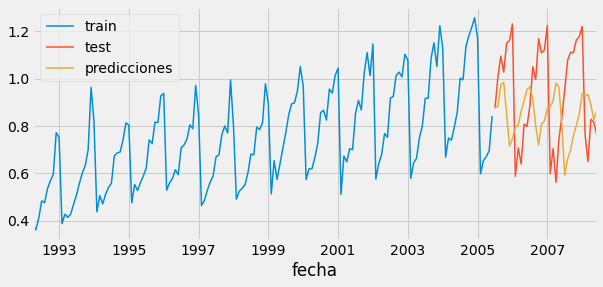

In [11]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test
<br>

Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el *mean squared error (mse)*.

In [12]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07326833976120374


### Ajuste de hiperparámetros (*tuning*)
<br>

El `ForecasterAutoreg` entrenado ha utilizado una ventana temporal de 6 lags y un modelo [Random Forest](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html) con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de lags e hiperparámetros, la librería **Skforecast** dispone de la función `grid_search_forecaster` con la que comparar los resultados obtenidos con cada configuración del modelo. 

Para una documentación más detallada visitar: [Hyperparameter tuning and lags selection](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

In [13]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 12.


loop lags_grid:   0%|                                               | 0/2 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

Los mejores resultados se obtienen si se utiliza una ventana temporal de 20 lags y una configuración de *Random Forest* {'max_depth': 3, 'n_estimators': 500}.

### Modelo final
<br> 

Finalmente, se entrena de nuevo un `ForecasterAutoreg` con la configuración óptima encontrada mediante validación. Este paso no es necesario si se indica `return_best = True` en la función `grid_search_forecaster`.

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Con la combinación óptima de hiperparámetros se consigue reducir notablemente el error de test.
<br><br>

### Backtesting
<br>

El proceso de *backtesting* consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo. 

**Backtesting con reentrenamiento**

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de *cross-validation* en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.

<img src="./images/diagram-backtesting-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y reentrenamiento en cada iteración.</i></font></center>

**Backtesting con reentrenamiento y tamaño de entrenamiento constante**

Similar a la estrategia anterior, pero, en este caso, el tamaño del conjunto de entrenamiento no se incrementa sino que la ventana de tiempo que abarca se desplaza. Esta estrategia se conoce también como *time series cross-validation* o *walk-forward validation*.

<img src="./images/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y set de entrenamiento con tamaño constante.</i></font></center>

**Backtesting sin reentrenamiento**

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

<img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps, sin reentrenamiento en cada iteración.</i></font></center>
<br>

La librería **skforecast** tiene implementadas las [estrategias de backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) mencionadas. Independientemente de cuál se utilice, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de *overfitting*.

Para este ejemplo, se sigue una estrategia de ***backtesting* con reentrenamiento**. Internamente, el proceso seguido por la función es el siguiente:

+ En la primera iteración, el modelo se entrena con las observaciones seleccionadas para el entrenamiento inicial (en este caso, 87). Después, las siguientes 36 observaciones se utilizan para validar las predicciones de este primer modelo (también 36).

+ En la segunda iteración, se reentrena el modelo añadiendo, al conjunto de entrenamiento inicial, las 36 observaciones de validación anteriores (87 + 36). De la misma manera, se establece como nuevo conjunto de validación las 36 observaciones siguientes.

+ Este proceso se repite hasta que se utilizan todas las observaciones disponibles. Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como *steps* se estén prediciendo.

In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

### Importancia predictores
<br>

Dado que el objeto `ForecasterAutoreg` utiliza modelos *scikit-learn*, una vez entrenado, se puede acceder a la importancia de los predictores. Cuando el regresor empleado es un `LinearRegression`, `Lasso` o `Ridge`, la importancia queda reflejada en los [coeficientes](https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html#Interpretaci%C3%B3n-del-modelo) del modelo. En regresores como `GradientBoostingRegressor`, `RandomForestRegressor` o `HistGradientBoostingRegressor`, la importancia de los predictores está basada en la [reducción de impureza](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html#Importancia-de-los-predictores).

*Nota: el método `get_feature_importance()` solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo `coef_` o `feature_importances_`.*

In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

## Forecasting autorregresivo recursivo con variables exógenas
<br>

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. En ciertos escenarios, es posible disponer de información sobre otras variables, **cuyo valor a futuro se conoce**, y pueden servir como predictoreres adicionales en el  modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. Esto mísmo es aplicable a múltiples variables exógenas.
<br><br>

### Datos

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

### ForecasterAutoreg

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

### Predicciones
<br>

Si el `ForecasterAutoreg` se entrena con una variable exógena, hay que pasarle el valor de esta variable al `predict()`. Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

In [ ]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

### Tuning del modelo

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train['exog_1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Random Forest {'max_depth': 10, 'n_estimators': 50}.

### Modelo final
<br>

Como se ha indicado `return_best = True` en `grid_search_forecaster`, tras la búsqueda, el objeto `ForecasterAutoreg` ha sido modificado y entrenado con la mejor combinación encontrada.

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

## Forecasting autorregresivo recursivo con predictores custom
<br>

En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos *n* valores puede servir para  capturar la tendencia de la serie.

La clase `ForecasterAutoregCustom` se comporta de forma muy similar a la clase `ForecasterAutoreg` vista en los apartados anteriores pero con la diferencia de que, es el usuario, quien define la función empleada para crear los predictores.

Se repite el primer ejemplo del documento, predecir los últimos 36 meses de la serie temporal, pero esta vez, utilizando como predictores los 10 primeros lags y la media móvil de los últimos 20 meses.
<br><br>

### Datos

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

### ForecasterAutoregCustom
<br>

Se crea y entrena un `ForecasterAutoregCustom` a partir de un regresor `RandomForestRegressor`. Para crear los predictores, se emplea la función `create_predictors()` que calcula los primeros 10 lags y la media móvil de los últimos 20 valores.

In [ ]:
# Función para calcular los predictores a partir de la serie temporal
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

Al crear el forecaster, el argumento `window_size` debe ser un valor, como mínimo, tan grande como la ventana que utiliza la función que crea los predictores. En este caso 20.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=datos_train['y'])
forecaster

Se puede acceder al código de la función utilizada para crear lo predictores.

In [ ]:
print(forecaster.source_code_create_predictors)

Mediante el método `create_train_X_y`, se puede acceder a las matrices que se crean internamente en el proceso de entrenamiento del forecaster.

In [ ]:
X, y = forecaster.create_train_X_y(y=datos_train['y'])
X.head(4)

In [ ]:
y.head(4)

### Predicciones

In [ ]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

### Ajuste de hiperparámetros (*tuning*)
<br>

Al utilizar la función `grid_search_forecaster` con un `ForecasterAutoregCustom`, no se indica el argumento `lags_grid`.

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size = False,
                        return_best = True,
                        verbose     = False
                    )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

### Modelo final

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

## Direct multi-step forecasting
<br>

Para conseguir predicciones a varios *steps* a futuro, los modelos `ForecasterAutoreg` y `ForecasterAutoregCustom` siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los *steps* que se desea predecir. Esta estrategia, normalmente conocida como *direct multi-step forecasting*, es computacionalmente más costosa que la recursiva puesto que requiere entrenar varios modelos. Sin embargo, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase `ForecasterAutoregDirect` y pueden incluir también una o múltiples variables exógenas.
<br><br>

### ForecasterAutoregDirect
<br>

A diferencia de cuando se utiliza `ForecasterAutoreg` o `ForecasterAutoregCustom`, en los modelos de tipo `ForecasterAutoregDirect` hay que indicar, en el momento de su creación, el número de *steps* que se quieren predecir. No es posible predecir *steps* más allá del valor definido en su creación.

Para este ejemplo, se utiliza como regresor un modelo lineal con penalización de [Lasso](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html#Lasso). Estos modelos requieren que los predictores se estandaricen, por lo que se combina con un `StandardScaler`. Para una documentación más detallada de como incluir *transformers* y *pipelines*, visitar: [skforecast with transformers and pipeline](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html).

In [ ]:
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # Este valor será remplazado en el grid search
             )

param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = datos_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(datos_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Lasso {'alpha': 0.021544}.

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

## Intervalos de predicción
<br>

Un intervalo de predicción define el espacio dentro del cual es de esperar que se encuentre el verdadero valor de $y$ con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro *Forecasting: Principles and Practice* [mútiples formas de estimar intervalos de predicción](https://otexts.com/fpp3/prediction-intervals.html), la mayoría los cuales requieren que los residuos (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a *bootstrapping*, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería **Skforecast** para los modelos de tipo `ForecasterAutoreg` y `ForecasterAutoregCustom`. Puede encontrarse más detalle en [skforecast prediction intervals](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/prediction-intervals.html).

<div>
<img src='./images/bootstrapped-prediction-interval.gif'/>
</div>

<center><font size='2.5'> <i>Diagrama de cómo crear intervalos de predicción utilizando el proceso de bootstrapping.</i></font></center>

<br><br>

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=datos_train['y'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
               )

predicciones.head(5)

In [ ]:
# Error de predicción
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones['pred']
            )

print(f"Error de test (mse): {error_mse}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_test['y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Backtest con intervalos de predicción
# ==============================================================================
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años
steps = 36
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['y'],
                            initial_train_size = len(datos) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                       )

print(f"Error de test (mse): {metrica}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos.loc[predicciones.index, 'y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[predicciones.index, 'y'] >= predicciones['lower_bound']) & \
                     (datos.loc[predicciones.index, 'y'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

## Métrica custom
<br>

En los procesos de *backtesting* (`backtesting_forecaster`) y optimización de hiperparámetros (`grid_search_forecaster`), además de las métricas *mean_squared_error*, *mean_absolute_error*  y *mean_absolute_percentage_error*, el usuario puede utilizar cualquier función que desee siempre y cuando cumpla lo siguiente:

+ Tiene como argumentos:

    + `y_true`: verdaderos valores de la serie.
    
    + `y_pred`: valores predichos.

+ Devuelve un valor numérico (`float` o `int`).

+ El modelo es mejor cuanto menor es la métrica. Esto únicamente es necesario si se quiere que la función `grid_search_forecaster` reentrene automáticamente el mejor modelo encontrado.

Gracias a esta flexibilidad, es posible evaluar la capacidad predictiva del modelo con métricas aplicables a escenarios muy diversos. Por ejemplo:

+ Considerar únicamente determinados meses, días u horas.
    
+ Considerar únicamente fechas que sean festivos.
    
+ Considerar únicamente el último *step* del horizonte predicho.

Véase un ejemplo en el que se quiere predecir un horizonte de 12 meses, pero únicamente considerar los últimos 3 meses de cada año para calcular la métrica de interés.

In [ ]:
# Métrica custom 
# ==============================================================================
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calcular el mean_absolute_error utilizando únicamente las predicciones de
    los últimos 3 meses del año.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [ ]:
# Backtesting 
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

## Cargar y guardar modelos
<br>

Los modelos generados con **Skforecast** se pueden cargar y guardar usando las librerías Pickle o Joblib**. A continuación se muestra un ejemplo sencillo utilizando. Para facilitar el proceso, dos funciones están disponibles: `save_forecaster` y `load_forecaster`. A continuación, se muestra un sencillo ejemplo. Para más información cosultar: [skforecast save and load forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/save-load-forecaster.html).

In [ ]:
# Crear forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)

In [ ]:
# Guardar modelo
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

In [ ]:
# Cargar modelo
forecaster_cargado = load_forecaster('forecaster.py')

In [ ]:
# Predicciones
forecaster_cargado.predict(steps=3)

## Uso de modelos en producción
<br>

En los proyectos relacionados con forecasting es frecuente que, como resultado de la etapa de experimentación y desarrollo, se genere un modelo. Para que este modelo consiga un impacto real en el negocio, se tiene que poder poner en producción y generar predicciones cada cierto tiempo, con las que tomar decisiones. Esta necesidad ha guiado en gran medida el desarrollo de la librería **Skforecast**.

Supóngase un caso de uso en el que se han de generar predicciones de forma semanal, por ejemplo, cada lunes el modelo tiene que predecir el resto de la semana. Una forma de conseguir este comportamiento es reentrenando el modelo semanalmente justo antes de que se ejecute la primera predicción y llamar a continuación al método `predict` del objeto forecaster.

Esta estrategia, si bien es sencilla, puede no ser posible de utilizar en la práctica por varias razones:

+ El entrenamiento del modelo es muy costoso y no puede ejecutarse con tanta frecuencia.

+ Ya no se dispone del histórico con el que se entrenó el modelo.

+ La frecuencia de predicción es tan elevada que no se dispone de tiempo para entrenar el modelo entre predicción y predicción.

En estos casos, es necesario que el modelo pueda ejecutarse en cualquier momento aunque no se haya entrenado recientemente. 

Todos los modelos generados por la librería **Skforecast** disponen en su método `predict` del argumento `last_window`. Gracias a él, se pueden proporcionar únicamente los valores pasados que necesita el modelo para crear los predictores autorregresivos (lags) y así generar las predicciones sin necesidad de reentrenar el modelo.

Para una documentación más detallada, visitar: [skforecast forecaster en producción](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/forecaster-in-production.html).

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])

En este caso, dado que el modelo utiliza como predictores los últimos 6 lags, `last_window` debe de contener como mínimo los 6 valores previos al momento donde se quiere iniciar la predicción.

In [ ]:
last_window = datos_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

Si el forecaster utiliza variables exógenas, además de `last_window`, se le deben proporcionar los valores futuros de las variables exógenas mediante el argumento `exog`.

## Información de sesión

In [ ]:
import session_info
session_info.show(html=False)

## Bibliografía
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [libro](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [libro](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [libro](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [libro](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Skforecast: forecasting series temporales con Python y Scikitlearn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.